# 0. Loading the required libraries

In [37]:
# Basic libraries:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import pickle

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# Computer vision:
import cv2
import skimage
from skimage.filters import laplace, sobel, roberts, gaussian,apply_hysteresis_threshold, threshold_yen, threshold_mean
from skimage.feature import canny
from skimage.util import invert
from skimage.morphology import skeletonize
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral,denoise_wavelet, estimate_sigma
from PIL import Image

# Personal Functions from separate Python file:
import mohamed_defined_filters as my_functions


# For bold printing:  
b1 = "\033[1m"
b2 = "\033[0;0m"

# Reading 2 images from the dataset for example throughout the notebook
car_img = plt.imread('../data/voc/automobile/000131.jpg') 
plane_img = plt.imread('../data/voc/plane/000033.jpg')
car_img_gray = cv2.cvtColor(car_img, cv2.COLOR_BGR2GRAY)
plane_img_gray = cv2.cvtColor(plane_img, cv2.COLOR_BGR2GRAY)

# 1. Objective and Data Description

## 1.1 Goal of the assignment 

The following assignment focuses on Image Classification, a ML task of assigning the most likely label to input images for c=given categories. 
And here we are required to build a classification pipeline to classify images of 3 categories: 

- Automobiles
- Planes
- Trains

I am thus here focusing on implementing feature-based classifiers.

I here will explore the results with various classifiers. I first start by building baseline models, and see how feature engineering and preprocessing affects the performance of these classifiers.

## 1.2 Dataset Description and Preparation

The VOC dataset is made up of images pertaining to the 3 classes mentionned above. 
I here start by preparing the data to properly use it in the later stages:

In [2]:
def prep_data (folder): # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            classnames.append(d) # use the folder name as the class name for this label
            files = os.listdir(os.path.join(root,d))
            for f in files:
                imgFile = os.path.join(root,d, f) # Load the image file
                img = plt.imread(imgFile)
                img = cv2.resize(img, (128, 128)) # Resizing all the images to insure proper reading
                features.append(img.ravel())
                labels = np.append(labels, class_id ) # Add it to the numpy array of labels
            class_id  += 1
            
    features = np.array(features) # Convert the list of features into a numpy array
    return features, labels, classnames

training_folder_name = '../data/voc/' # The images are in a folder named 'voc'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from automobile
Reading data from plane
Reading data from train
240 features
240 labels
3 classes: ['automobile', 'plane', 'train']


We can now look at the shapes of the arrays -  I should have a two-dimensional array of features (each image is itself an array), and one dimensional array of labels (each label is an integer value).

In [3]:
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Feature Shape: (240, 49152)
Labels Shape: (240,)


# 2. Building Baseline Models

## 2.1 Spliting the data

Now that I have prepared the images, I can split it into training (70%) and test (30%) subsets:

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)

print('The number of Training records is:',Y_train.size)
print('The number of Test records is:',Y_test.size)

The number of Training records is: 168
The number of Test records is: 72


## 2.2 Training the classification models

I can now turn to trying various algorithms and comparing their results with simple pipelines that will do the following:

1. Normalize the pixel values so that they are scaled between 0 and 1 (to prevent high pixel density values from dominating the model training).
2. Train the model using the algorithm assigned. Here we explore the following algorithms: ``Decision Tree Classifier`` , ``Random Forrest``, ``XGBClassifier``, ``LGBMClassifier``, ``Multi-layer Perceptron classifier``, ``CatBoostClassifier``, ``SVM``, ``Naive Bayes``, and ``SGD``.

Based on the performances of the models, we will be able to initially filter and keep those that seem the most promising for the rest of the problem.

In [11]:
X_train_float = X_train.astype('float64') # Converting the training features to floats so they can be scaled

# The models:
img_pipeline_dt = Pipeline([('norm', MinMaxScaler()), #   1. Normalize the image arrays
                         ('classify', DecisionTreeClassifier(random_state=5)),]) #   2. Train a classification model

img_pipeline_rf = Pipeline([('norm', MinMaxScaler()),
                         ('classify', RandomForestClassifier(random_state=5)),])

img_pipeline_xgb = Pipeline([('norm', MinMaxScaler()),
                         ('classify', XGBClassifier(random_state=5)),])

img_pipeline_lgb = Pipeline([('norm', MinMaxScaler()),
                         ('classify', LGBMClassifier(random_state=5)),])

img_pipeline_mlp = Pipeline([('norm', MinMaxScaler()),
                         ('classify', MLPClassifier(random_state =5)),])

img_pipeline_catb = Pipeline([('norm', MinMaxScaler()),
                         ('classify', CatBoostClassifier(random_seed=5)),])

img_pipeline_nb = Pipeline([('norm', MinMaxScaler()),
                         ('classify', MultinomialNB()),])

img_pipeline_svm = Pipeline([('norm', MinMaxScaler()),
                         ('classify', svm.SVC()),])

img_pipeline_sdg = Pipeline([('norm', MinMaxScaler()),
                         ('classify', SGDClassifier(random_state = 5)),])


# Use the pipeline to fit a model to the training data
dt_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
print('Decision Tree classifier trained!')
      
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)
print('Random Forest classifier trained!')
      
xgb_classifier = img_pipeline_xgb.fit(X_train_float, Y_train)
print('XGBoost Classifier trained!')
      
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)
print('LGBM Classifier trained!')
      
mlp_classifier = img_pipeline_mlp.fit(X_train_float, Y_train) 
print('Multi-layer Perceptron classifier trained!')
      
#catb_classifier = img_pipeline_catb.fit(X_train_float, Y_train) ## This algorithm took too much time to run and so I abandonned it
#print('Catboost classifier trained!')
      
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
print('Naive Bayes classifier trained!')

svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
print('SVM trained!')

sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('SGD trained!')

Decision Tree classifier trained!
Random Forest classifier trained!
XGBoost Classifier trained!
LGBM Classifier trained!
Multi-layer Perceptron classifier trained!
Naive Bayes classifier trained!
SVM trained!
SGD trained!


## 2.3 Evaluating the baseline models

With the models trained, I can use them to predict labels for the test data and evaluate their precision, recall, and simple accuracy using the known labels. Then I will plot the confusion matrices of each to evaluate how well the models perform for each class label.

### 2.3.1 Decision Tree Classifiers Metrics

In [508]:
X_test_float = X_test.astype('float64') # Converting the test features for scaling
print('Decision Tree Classifier Metrics:')
predictions_dt = dt_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_dt, target_names=classnames))
print('Accuracy of the Decision Tree Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_dt)))

Decision Tree Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.62      0.50      0.55        26
       plane       0.58      0.81      0.68        26
       train       0.67      0.50      0.57        20

    accuracy                           0.61        72
   macro avg       0.62      0.60      0.60        72
weighted avg       0.62      0.61      0.60        72

Accuracy of the Decision Tree Classifier: 61.11%


### 2.3.2 Random Forest Classifier Metrics

In [510]:
print('Random Forest Classifier Metrics:')
predictions_rf = rf_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_rf, target_names=classnames))
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))

Random Forest Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.84      0.81      0.82        26
       plane       0.81      0.85      0.83        26
       train       0.70      0.70      0.70        20

    accuracy                           0.79        72
   macro avg       0.78      0.78      0.78        72
weighted avg       0.79      0.79      0.79        72

Accuracy of the Random Forrest Classifier: 79.17%


### 2.3.3 XGBoost Classifier Metrics

In [511]:
print('XGBoost Classifier Metrics:')
predictions_xgb = xgb_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_xgb, target_names=classnames))
print('Accuracy of the XGBoost Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_xgb)))

XGBoost Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.80      0.77      0.78        26
       plane       0.77      0.88      0.82        26
       train       0.71      0.60      0.65        20

    accuracy                           0.76        72
   macro avg       0.76      0.75      0.75        72
weighted avg       0.76      0.76      0.76        72

Accuracy of the XGBoost Classifier: 76.39%


### 2.3.4 LGBM Classifier Metrics

In [513]:
print('LGBM Classifier Metrics:')
predictions_lgb = lgb_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_lgb, target_names=classnames))
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))

LGBM Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.81      0.85      0.83        26
       plane       0.85      0.88      0.87        26
       train       0.72      0.65      0.68        20

    accuracy                           0.81        72
   macro avg       0.80      0.79      0.79        72
weighted avg       0.80      0.81      0.80        72

Accuracy of the LGBM Classifier: 80.56%


### 2.3.5 MLP Classifier Metrics

In [514]:
print('MLP Classifier Metrics:')
predictions_mlp = mlp_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_mlp, target_names=classnames))
print('Accuracy of the MLP Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_mlp)))

MLP Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.00      0.00      0.00        26
       plane       0.40      0.38      0.39        26
       train       0.40      0.95      0.57        20

    accuracy                           0.40        72
   macro avg       0.27      0.44      0.32        72
weighted avg       0.26      0.40      0.30        72

Accuracy of the MLP Classifier: 40.28%


/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.3.6 SGD Classifier

In [515]:
print('SGD Classifier Metrics:')
predictions_sgd = sgd_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_sgd, target_names=classnames))
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

SGD Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.67      0.54      0.60        26
       plane       0.68      0.81      0.74        26
       train       0.65      0.65      0.65        20

    accuracy                           0.67        72
   macro avg       0.66      0.67      0.66        72
weighted avg       0.67      0.67      0.66        72

Accuracy of the SGD Classifier: 66.67%


### 2.3.7  Naive Bayes Classifier Metrics 

In [516]:
print('Naive Bayes Metrics:')
predictions_nb = nb_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_nb, target_names=classnames))
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))

Naive Bayes Metrics:
              precision    recall  f1-score   support

  automobile       0.53      0.65      0.59        26
       plane       0.57      0.31      0.40        26
       train       0.62      0.80      0.70        20

    accuracy                           0.57        72
   macro avg       0.57      0.59      0.56        72
weighted avg       0.57      0.57      0.55        72

Accuracy of the Naive Bayes Classifier: 56.94%


### 2.3.8 SVM Metrics

In [517]:
print('SVM Metrics:')
predictions_svm = svm_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_svm, target_names=classnames))
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))

SVM Metrics:
              precision    recall  f1-score   support

  automobile       0.62      0.50      0.55        26
       plane       0.58      0.81      0.68        26
       train       0.67      0.50      0.57        20

    accuracy                           0.61        72
   macro avg       0.62      0.60      0.60        72
weighted avg       0.62      0.61      0.60        72

Accuracy of the Naive Bayes Classifier: 61.11%


### 2.3.9 Confusion matrices of the models

<Figure size 432x288 with 0 Axes>

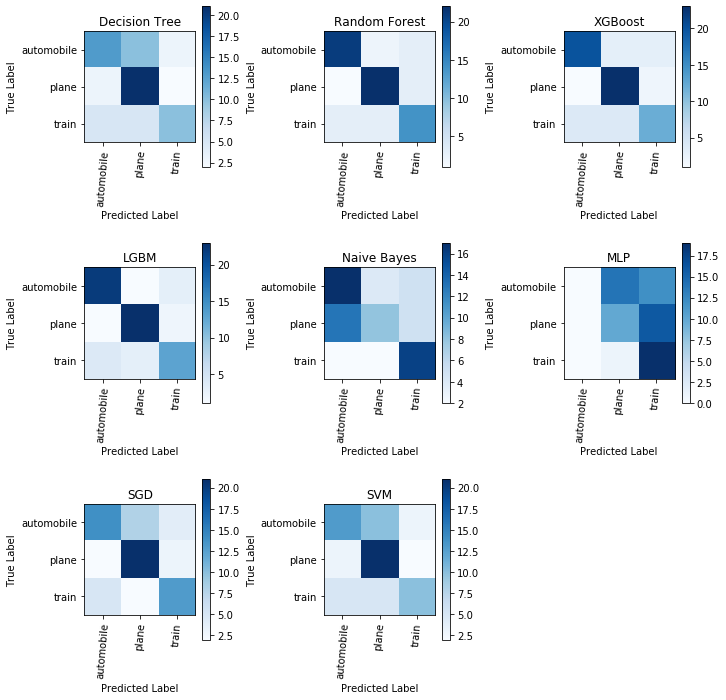

In [523]:
print()
fig = plt.figure();
plt.figure(figsize=(10,10))
plt.subplot(3, 3, 1)
cm_dt = confusion_matrix(Y_test, np.round(predictions_dt, 0))
plt.imshow(cm_dt, interpolation="nearest", cmap=plt.cm.Blues) # Plot confusion matrix as heatmap
plt.colorbar()
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree")

cm_rf = confusion_matrix(Y_test, np.round(predictions_rf, 0))
plt.subplot(3, 3, 2)
plt.imshow(cm_rf, interpolation="nearest", cmap=plt.cm.Blues) # Plot confusion matrix as heatmap
plt.colorbar()
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest")

cm_xgb = confusion_matrix(Y_test, np.round(predictions_xgb, 0)) 
plt.subplot(3, 3, 3)
plt.imshow(cm_xgb, interpolation="nearest", cmap=plt.cm.Blues) # Plot confusion matrix as heatmap
plt.colorbar()
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost")

cm_lgb = confusion_matrix(Y_test, np.round(predictions_lgb, 0)) 
plt.subplot(3, 3, 4)
plt.imshow(cm_lgb, interpolation="nearest", cmap=plt.cm.Blues) # Plot confusion matrix as heatmap
plt.colorbar()
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LGBM")

cm_nb = confusion_matrix(Y_test, np.round(predictions_nb, 0)) 
plt.subplot(3, 3, 5)
plt.imshow(cm_nb, interpolation="nearest", cmap=plt.cm.Blues) # Plot confusion matrix as heatmap
plt.colorbar()
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Naive Bayes")

cm_mlp = confusion_matrix(Y_test, np.round(predictions_mlp, 0)) 
plt.subplot(3, 3, 6)
plt.imshow(cm_mlp, interpolation="nearest", cmap=plt.cm.Blues) # Plot confusion matrix as heatmap
plt.colorbar()
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MLP")

cm_sgd = confusion_matrix(Y_test, np.round(predictions_sgd, 0)) 
plt.subplot(3, 3, 7)
plt.imshow(cm_sgd, interpolation="nearest", cmap=plt.cm.Blues) # Plot confusion matrix as heatmap
plt.colorbar()
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SGD")

cm_svm = confusion_matrix(Y_test, np.round(predictions_svm, 0)) 
plt.subplot(3, 3, 8)
plt.imshow(cm_svm, interpolation="nearest", cmap=plt.cm.Blues) # Plot confusion matrix as heatmap
plt.colorbar()
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SVM")
plt.tight_layout() 
plt.show();

## 2.4 Concluding on the Baseline Models

The accuracy of the 8 trained models can be summarized below:

| LGBM | R. Forest | XGBoost | SGD | D. Tree | SVM | Naive Bayes | MLP |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 80.56% | 79.17% |76.39% | 66.67% | 61.11% | 61.11% | 56.94% | 40.28% |


- From the measures and the confusion matrices, ensemble models seem to perform best for this problem with LGBM, Random Forest and XGBoost having the highest accuracies.

- From the confusion matrices, I believe that the Naive Bayes model, if tuned properly could yield good predictions, indeed it is only missing a proper classification for planes.

- The Multi-Perceptron model do not look proper for this problem and so I will drop it at this stage. 

- In training, I also dropped the CatBoost Classifiers due to its high training time.

- I also believe that focusing on the Random Forest would mean I can drop the Decision Tree at this stage.

- I thus continue to feature engineering with the following models: LGBM,  Random Forest, XGBoost, SGD, SVM, and Naive Bayes.

# 3. Appraoach I: Histogram of Oriented Gradient

For this approach, I decide to use the Histogram of Oriented Gradients (HOG) to apply feature reduction and try lowering the complexity of the problem but at the same time maintaining as much variation as possible to be able to increase the performance of my models.

I will first try explaining the HOG procedure and then apply it with my models


## 3.1 Explanation of the HOG
As mentionned in this great [article](https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/#), HOG are descriptors most oftenly used in Computer Vision for object detection. However, these descriptors can be fed into a ML classifier and thus be used for quantifying and representing some shapes and textures in the analysed images. In many applications of HOG, they have been mainly used with the Linear SVM classifier, but here, I will apply it to the 6 selected models above.

HOG descriptors are excellent descriptors for image classification because of the following:

1. They are used to describe the appearance of objects as well as their structural shape, thus making it easier to recognize planes from trains or cars. 
2. They also capture edge directions and local intensity gradients, making it a good texture descriptor as well.

To illustrate what I mean, I here use 2 images from the studied dataset to illustrate what the descriptor is actually doing:

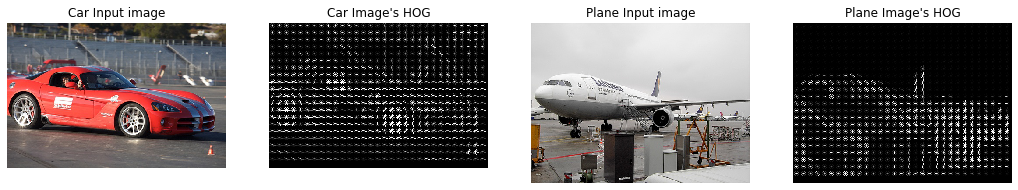

In [572]:
# Applying the HOG Descriptor on Each image
fd, hog_image_car = hog(car_img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
fd, hog_image_plane = hog(plane_img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

# Rescaling histogram for better display
hog_image_car_rescaled = exposure.rescale_intensity(hog_image_car, in_range=(0, 10)) 
hog_image_plane_rescaled = exposure.rescale_intensity(hog_image_plane, in_range=(0, 10))

# Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 18), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(car_img, cmap=plt.cm.gray)
ax1.set_title('Car Input image')
ax2.axis('off')
ax2.imshow(hog_image_car_rescaled, cmap=plt.cm.gray)
ax2.set_title("Car Image's HOG")
ax3.axis('off')
ax3.imshow(plane_img, cmap=plt.cm.gray)
ax3.set_title('Plane Input image')
ax4.axis('off')
ax4.imshow(hog_image_plane_rescaled, cmap=plt.cm.gray)
ax4.set_title("Plane Image's HOG")
plt.show()

So as can be seen, I get a simplified representation of the images by extracting the useful information and throwing away unessary information for their classification.

As can also be seen from the function used, the main parameters I can play with are: the  orientations, the  pixels_per_cell , and the cells_per_block parameters. I will try some combinations later on to see which ones yield the best results.

So what I will be looking to do here is following this pipeline: 
1. Extracting HOG features from my training images to characterize and quantify images for the 3 categories;
2. Training 6 ML classifiers to distinguish between cars, trains, and planes.

Also, it is worth mentionning that the HOG descriptor gives in return a real-valued feature vector. And the dimensionality of this feature vector is dependent on the parameters chosen for  mentioned above.

## 3.2 Application of the HOG Pipelines

In [597]:
# I here add the HOG transformation to the initially used function
def process_data_with_hog (folder): 
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            classnames.append(d) 
            files = os.listdir(os.path.join(root,d))
            for f in files:
                imgFile = os.path.join(root,d, f) 
                img = plt.imread(imgFile)
                resized_img = cv2.resize(img, (128, 128))
                gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY) # I first transform the images to gray
                
                # Here is the HOG function
                hog = skimage.feature.hog(gray, block_norm='L2-Hys', pixels_per_cell=(8, 8),
                                          cells_per_block=(3, 3), orientations=7,  transform_sqrt=True)
                features.append(hog.ravel())
                labels = np.append(labels, class_id ) 
            class_id  += 1
            
    features = np.array(features) 
    return features, labels, classnames

training_folder_name = '../data/voc/' 
features, labels, classnames = process_data_with_hog(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from automobile
Reading data from plane
Reading data from train
240 features
240 labels
3 classes: ['automobile', 'plane', 'train']


In [598]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, 
                                                    test_size=0.30, random_state=7)

print('The number of Training records is:',Y_train.size)
print('The number of Test records is:',Y_test.size)

The number of Training records is: 168
The number of Test records is: 72


### 3.2.1 Training the models

In [600]:
# I rerun the models on the newly established Data:
X_train_float = X_train.astype('float64') 
      
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)
print('Random Forest classifier trained!')
      
xgb_classifier = img_pipeline_xgb.fit(X_train_float, Y_train)
print('XGBoost Classifier trained!')
      
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)
print('LGBM Classifier trained!')
      
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
print('Naive Bayes classifier trained!')

svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
print('SVM trained!')

sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('SGD trained!')

Random Forest classifier trained!
XGBoost Classifier trained!
LGBM Classifier trained!
Naive Bayes classifier trained!
SVM trained!
SGD trained!


### 3.2.2 Evaluating the models

In [601]:
# I can evaluate them all now:
X_test_float = X_test.astype('float64') # Converting the test features for scaling
print(b1 + 'LGBM Classifier Metrics:' + b2)
predictions_lgb = lgb_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_lgb, target_names=classnames))
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))

print('\n' + b1 + 'Random Forest Classifier Metrics:' + b2)
predictions_rf = rf_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_rf, target_names=classnames))
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))

print('\n' + b1 + 'XGBoost Classifier Metrics:' + b2)
predictions_xgb = xgb_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_xgb, target_names=classnames))
print('Accuracy of the XGBoost Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_xgb)))

print('\n' + b1 + 'Naive Bayes Metrics:' + b2)
predictions_nb = nb_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_nb, target_names=classnames))
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))

print('\n' + b1 + 'SVM Metrics:' + b2)
predictions_svm = svm_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_svm, target_names=classnames))
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))

print('\n' + b1 + 'SGD Metrics:' + b2)
predictions_sgd = sgd_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_sgd, target_names=classnames))
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

LGBM Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.85      0.85      0.85        26
       plane       0.91      0.81      0.86        26
       train       0.83      0.95      0.88        20

    accuracy                           0.86        72
   macro avg       0.86      0.87      0.86        72
weighted avg       0.86      0.86      0.86        72

Accuracy of the LGBM Classifier: 86.11%

Random Forest Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.93      0.96      0.94        26
       plane       0.95      0.81      0.88        26
       train       0.87      1.00      0.93        20

    accuracy                           0.92        72
   macro avg       0.92      0.92      0.92        72
weighted avg       0.92      0.92      0.92        72

Accuracy of the Random Forrest Classifier: 91.67%

XGBoost Classifier Metrics:
              precision    recall  f1-score   support

  au

It is very clear that the HOG descriptor was highly effective in helping for the classification of the images in the proper categories. Especially the Random Forest Model with almost a 92% accuracy. There might be a little of overfitting but we can look at the confusion matrices to get a better sense of the results:

The Matrices of the Models after applying the HOG descriptor are:


<Figure size 432x288 with 0 Axes>

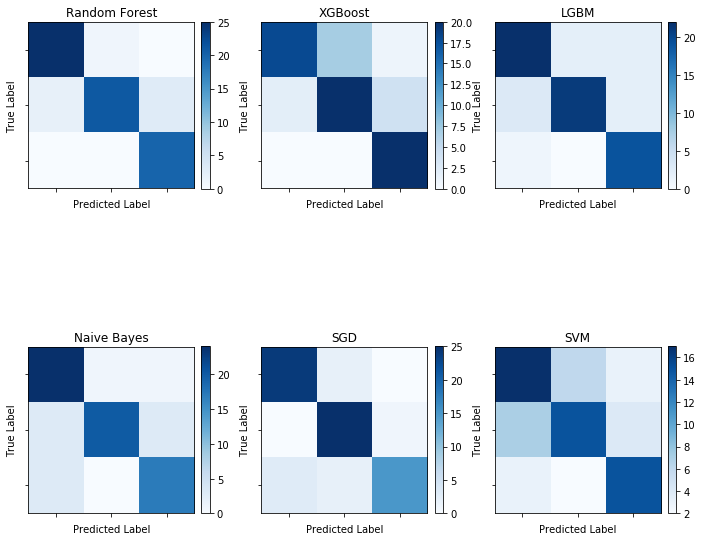

In [637]:
print("The Matrices of the Models after applying the HOG descriptor are:")
fig = plt.figure(); plt.figure(figsize=(10,10));

cm_rf = confusion_matrix(Y_test, np.round(predictions_rf, 0)); plt.subplot(2, 3, 1)
plt.imshow(cm_rf, interpolation="nearest", cmap=plt.cm.Blues); plt.colorbar(fraction=0.046, pad=0.04); plt.xticks(tick_marks, classnames, rotation=85); plt.yticks(tick_marks, classnames);
plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("Random Forest")

cm_xgb = confusion_matrix(Y_test, np.round(predictions_xgb, 0)) ; plt.subplot(2, 3, 2)
plt.imshow(cm_xgb, interpolation="nearest", cmap=plt.cm.Blues) ; plt.colorbar(fraction=0.046, pad=0.04); plt.xticks(tick_marks, classnames, rotation=85); plt.yticks(tick_marks, classnames);
plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("XGBoost")

cm_lgb = confusion_matrix(Y_test, np.round(predictions_lgb, 0)) ; plt.subplot(2, 3, 3)
plt.imshow(cm_lgb, interpolation="nearest", cmap=plt.cm.Blues) ; plt.colorbar(fraction=0.046, pad=0.04); plt.xticks(tick_marks, classnames, rotation=85); plt.yticks(tick_marks, classnames); 
plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("LGBM")

cm_nb = confusion_matrix(Y_test, np.round(predictions_nb, 0)); plt.subplot(2, 3, 4)
plt.imshow(cm_nb, interpolation="nearest", cmap=plt.cm.Blues) ; plt.colorbar(fraction=0.046, pad=0.04); plt.xticks(tick_marks, classnames, rotation=85); plt.yticks(tick_marks, classnames);
plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("Naive Bayes")

cm_sgd = confusion_matrix(Y_test, np.round(predictions_sgd, 0)); plt.subplot(2, 3, 5)
plt.imshow(cm_sgd, interpolation="nearest", cmap=plt.cm.Blues); plt.colorbar(fraction=0.046, pad=0.04); plt.xticks(tick_marks, classnames, rotation=85); plt.yticks(tick_marks, classnames);
plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("SGD")

cm_svm = confusion_matrix(Y_test, np.round(predictions_svm, 0)); plt.subplot(2, 3, 6)
plt.imshow(cm_svm, interpolation="nearest", cmap=plt.cm.Blues) ; plt.colorbar(fraction=0.046, pad=0.04); plt.xticks(tick_marks, classnames, rotation=85); plt.yticks(tick_marks, classnames);
plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("SVM")
plt.tight_layout() ; plt.show();

We now clearly see the largest values on the diagonal, indicating that most predictions are correct, even if some mistakes are still present. 

Another observation we can derive from here is that automobiles seem to be the easiest class to predict overall with the upper left square the darkest one in most cases.

I next try running a grid search to see if I can achieve a performancee improvement:

## 3.3 GridSearch HyperParameter Optimization 
I here used the great guide for optimization explained in [this article](https://learning.oreilly.com/library/view/statistics-for-machine/9781788295758/b86afd8a-5b89-4367-8841-76a5d3520eb3.xhtml).

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, 
                                                    test_size=0.30, random_state=7)
pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('clf', RandomForestClassifier(random_state=5)),])

parameters = {'clf__n_estimators':(2000,3000,5000),'clf__max_depth':(5,15,30), 
              'clf__min_samples_split':(2,3),'clf__min_samplers_leaf':(1,2)  }

grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=5,verbose=1, scoring='accuracy') 
grid_search.fit(X_train,Y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('norm',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                   

In [17]:
print ('Best Training score: %0.3f' % grid_search.best_score_) 
print ('Best parameters set:') 
best_parameters = grid_search.best_estimator_.get_params()  

Best Training score: 0.875
Best parameters set:


In [19]:
for param_name in sorted(parameters.keys()): 
    print ('\t%s: %r' % (param_name, best_parameters[param_name])) 

	clf__max_depth: 5
	clf__min_samples_leaf: 1
	clf__min_samples_split: 2
	clf__n_estimators: 2000


In [21]:
predictions = grid_search.predict(X_test) 

In [24]:
from sklearn.metrics import classification_report
print ("Testing accuracy:",round(accuracy_score(Y_test, predictions),4)) 
print ("\nComplete report of Testing data\n",classification_report(Y_test, predictions)) 

Testing accuracy: 0.8889

Complete report of Testing data
               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        26
         1.0       0.91      0.77      0.83        26
         2.0       0.83      1.00      0.91        20

    accuracy                           0.89        72
   macro avg       0.89      0.90      0.89        72
weighted avg       0.89      0.89      0.89        72



The Grid Search did not improve the score. Probably a more extensive search would allow to find a better performance even if it already seems pretty high.

I next turn to more preprocessing, trying to assess the effect of Tresholding, Edge Detection, Denoising, Skeletizing among other processes. In the 3rd approach I will come back to combining insights from this part and the next part to try improving the performance gotten so far.

# 4. Approach II: Preprocessing with Filters

After applying the HOG to get image descriptions and classify based on that, I here try using various filters to see if I am able to match the performance atained previously.

Because a lot of the code used earlier is used here, and to avoid constant repetition, for this approach, I do the following to simplify the structure of the code:

1. Define the filter functions in a separate file `(mohamed_defined_filters.py)` and call them here for each filter applied;
2. Simplify the whole code into one cell which basically follows the same steps as before: loading images / preprocessing / applying the filters / Splitting the Data / Training / Evaluating.

I also only look at the accuracy of the models and analyse further those filters that result in promising results.


## 4.1 Thresholding
As greatly explained in [this article](https://datacarpentry.org/image-processing/07-thresholding/#:~:text=Thresholding%20is%20a%20type%20of,is%20simply%20black%20and%20white.),
thresholding is considered a type of image segmentation, in which we modify the pixels of the images studied to make the image easier to analyze for our models. 

In thresholding, we basically convert an image from color or grayscale into a binary one (a black and white image thus). 

Thus, in most cases, we use thresholding to select areas of interest of the images, and at the same time ignoring the parts we are not interested with. 

This concept can be illustrated in the following graphs from image we are analyzing:

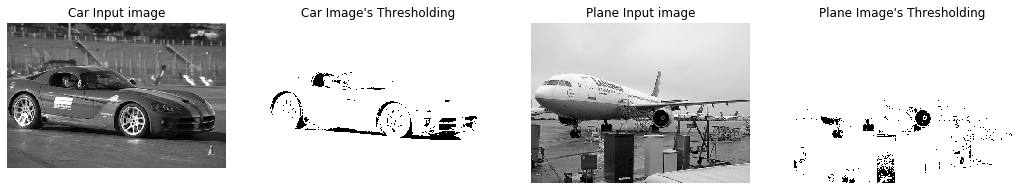

In [70]:
# Applying the Hysteresis thresholding 
hyst_image_car = apply_hysteresis_threshold(car_img_gray, 15, 20)
hyst_image_plane = apply_hysteresis_threshold(plane_img_gray, 15, 20)

# Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 18), sharex=True, sharey=True)
ax1.axis('off'); ax1.imshow(car_img_gray, cmap=plt.cm.gray); ax1.set_title('Car Input image')
ax2.axis('off'); ax2.imshow(hyst_image_car, cmap=plt.cm.gray); ax2.set_title("Car Image's Thresholding")
ax3.axis('off'); ax3.imshow(plane_img_gray, cmap=plt.cm.gray); ax3.set_title('Plane Input image')
ax4.axis('off'); ax4.imshow(hyst_image_plane, cmap=plt.cm.gray); ax4.set_title("Plane Image's Thresholding")
plt.show()

In the following section, I will analyze the impact of the Hysteresis thresholding, Mean thresholding, and Yen thresholding.

### 4.1.1 Hysteresis thresholding
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=filter#skimage.filters.apply_hysteresis_threshold): *This algorithm finds regions where image is greater than high OR image is greater than low and that region is connected to a region greater than high.*

In [9]:
# Processing the image data
features, labels, classnames = my_functions.hyst_tresh_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Reading data from automobile
Reading data from plane
Reading data from train
Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 27.78%
Accuracy of the Random Forrest Classifier: 41.67%
Accuracy of the Naive Bayes Classifier: 27.78%
Accuracy of the SVM Classifier: 38.89%
Accuracy of the SGD Classifier: 29.17%


### 4.1.2 Mean thresholding
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=filter#skimage.filters.threshold_mean): *This function returns threshold value based on the mean of grayscale values.*

In [5]:
# Processing the image data
features, labels, classnames = my_functions.threshold_mean_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 43.06%
Accuracy of the Random Forrest Classifier: 37.50%
Accuracy of the Naive Bayes Classifier: 27.78%
Accuracy of the SVM Classifier: 37.50%
Accuracy of the SGD Classifier: 52.78%


### 4.1.2 Yen thresholding
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=filter#skimage.filters.threshold_mean): *This function returns threshold value based on Yen’s method.*(Further documentation could be found [here](https://doi.org/10.1109/83.366472).

In [4]:
# Processing the image data
features, labels, classnames = my_functions.threshold_yen_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 43.06%
Accuracy of the Random Forrest Classifier: 37.50%
Accuracy of the Naive Bayes Classifier: 27.78%
Accuracy of the SVM Classifier: 41.67%
Accuracy of the SGD Classifier: 27.78%


With the very low performance matrices, we can easily see that thresholding do not help for our problem here. I next turn to edge detection.

## 4.2 Edge Detectors 

As highlighted in [Python Image Preprocessing Cookbook](https://www.packtpub.com/data/python-image-processing-cookbook), edge detection is a preprocessing technique in which we usually feed a two-dimensional (grayscale) image and we obtain a set of curves as the output. 

The pixels that make up the edges in the analyzed images are the ones that exhibit sudden  discontinuities in the image intensity. And thus the goal here will ne to detect these changes. 

The idea here would be that by detecting the edgees of cars, trains, and planes, the model would be able to perform better.

An illustration of this concept is explained below:

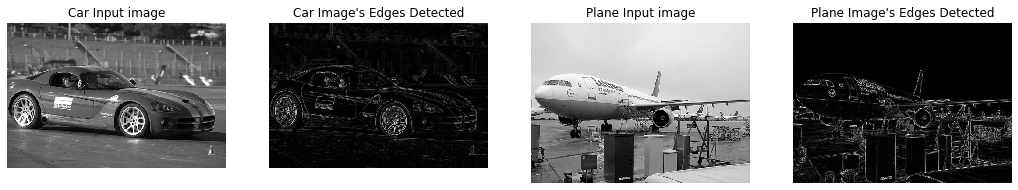

In [71]:
# Applying the Roberts Filter for Edge detection on Each image
rob_image_car = roberts_filt = roberts(car_img_gray)
rob_image_plane = roberts_filt = roberts(plane_img_gray)

# Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 18), sharex=True, sharey=True)
ax1.axis('off'); ax1.imshow(car_img_gray, cmap=plt.cm.gray); ax1.set_title('Car Input image')
ax2.axis('off'); ax2.imshow(rob_image_car, cmap=plt.cm.gray); ax2.set_title("Car Image's Edges Detected")
ax3.axis('off'); ax3.imshow(plane_img_gray, cmap=plt.cm.gray); ax3.set_title('Plane Input image')
ax4.axis('off'); ax4.imshow(rob_image_plane, cmap=plt.cm.gray); ax4.set_title("Plane Image's Edges Detected")
plt.show()

As can be seen, the detector is able to highlight the contour of the car as well as the plane (even if with more difficulties). 

I here will assess the effects of the following detectors: Laplace, Sobel, and Roberts.

### 4.2.1 Laplace Filter
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=filter#skimage.filters.laplace): *This function finds the edges of an image using the Laplace operator.*

In [8]:
# Processing the image data
features, labels, classnames = my_functions.laplace_filt(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Reading data from automobile
Reading data from plane
Reading data from train
Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 73.61%
Accuracy of the Random Forrest Classifier: 79.17%
Accuracy of the Naive Bayes Classifier: 55.56%
Accuracy of the SVM Classifier: 54.17%
Accuracy of the SGD Classifier: 54.17%


### 4.2.2 Sobel Filter
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=filter#skimage.filters.sobel): *This function finds the edges in an image using the Sobel filter.*

In [4]:
# Processing the image data
features, labels, classnames = my_functions.sobel_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 81.94%
Accuracy of the Random Forrest Classifier: 79.17%
Accuracy of the Naive Bayes Classifier: 68.06%
Accuracy of the SVM Classifier: 54.17%
Accuracy of the SGD Classifier: 70.83%


### 4.2.3 Roberts Filter
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=filter#skimage.filters.roberts): *This function finds the the edge magnitude using Roberts’ cross operator.*

In [4]:
# Processing the image data
features, labels, classnames = my_functions.roberts_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 72.22%
Accuracy of the Random Forrest Classifier: 79.17%
Accuracy of the Naive Bayes Classifier: 68.06%
Accuracy of the SVM Classifier: 61.11%
Accuracy of the SGD Classifier: 69.44%


### 4.2.4 Canny Filter
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=canny#skimage.feature.canny): *This function applies an Edge filter to the image using the Canny algorithm.*

In [5]:
# Processing the image data
features, labels, classnames = my_functions.canny_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 68.06%
Accuracy of the Random Forrest Classifier: 69.44%
Accuracy of the Naive Bayes Classifier: 72.22%
Accuracy of the SVM Classifier: 58.33%
Accuracy of the SGD Classifier: 65.28%


Overall, the performance of the models with edges detected did not improve but reduced slightly. Maybe that one of these transformation along with the HOG descriptor could yield interesting results.

## 4.3 Lines: Skeletonize

Skeletonization is a method that reduces binary objects to 1 pixel wide representations. This transformation can be useful for feature extraction, and when we are interested in representing an object’s topology.

Here is an illustration of what it would do to our analysed images:

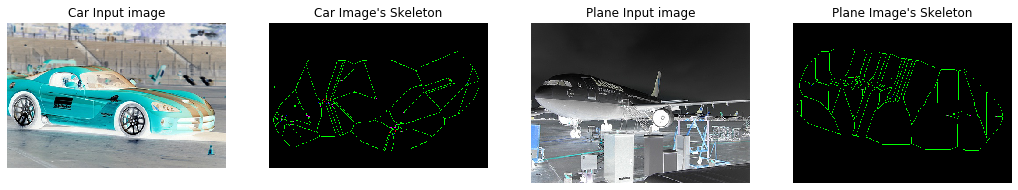

In [81]:
# Inverting the images to apply the function:
car_img_sk = invert(car_img)
plane_img_sk = invert(plane_img)

# Applying the HOG Descriptor on Each image
hog_image_car = skeletonize(car_img_sk)
hog_image_plane = skeletonize(plane_img_sk)

# Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 18), sharex=True, sharey=True)
ax1.axis('off'); ax1.imshow(car_img_sk, cmap=plt.cm.gray); ax1.set_title('Car Input image')
ax2.axis('off'); ax2.imshow(hog_image_car, cmap=plt.cm.gray); ax2.set_title("Car Image's Skeleton")
ax3.axis('off'); ax3.imshow(plane_img_sk, cmap=plt.cm.gray); ax3.set_title('Plane Input image')
ax4.axis('off'); ax4.imshow(hog_image_plane, cmap=plt.cm.gray); ax4.set_title("Plane Image's Skeleton")
plt.show()

In [4]:
# Processing the image data
features, labels, classnames = my_functions.skeletonize_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 45.83%
Accuracy of the Random Forrest Classifier: 45.83%
Accuracy of the Naive Bayes Classifier: 20.83%
Accuracy of the SVM Classifier: 38.89%
Accuracy of the SGD Classifier: 30.56%


The performance metrics for the various algorithms clearly highlight here that skeletonization is not useful for out problem.

## 4.4 Denoising
One way to enhance the images we have would be through denoising.  Image denoising could be a crucial image processing task that should bee tried in most image classification problems. It basically consists of removing any noise we might have in our images.

Our images seem pretty clean but I nonetheless apply here 3 different denoisers and assess the effect:

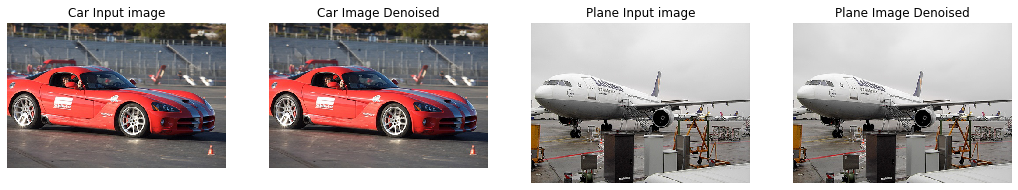

In [85]:
# Applying the HOG Descriptor on Each image
deno_image_car = denoise_wavelet(car_img, multichannel=True, rescale_sigma=True)
deno_image_plane = denoise_wavelet(plane_img, multichannel=True, rescale_sigma=True)

# Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 18), sharex=True, sharey=True)
ax1.axis('off'); ax1.imshow(car_img, cmap=plt.cm.gray); ax1.set_title('Car Input image')
ax2.axis('off'); ax2.imshow(deno_image_car, cmap=plt.cm.gray); ax2.set_title("Car Image Denoised")
ax3.axis('off'); ax3.imshow(plane_img, cmap=plt.cm.gray); ax3.set_title('Plane Input image')
ax4.axis('off'); ax4.imshow(deno_image_plane, cmap=plt.cm.gray); ax4.set_title("Plane Image Denoised")
plt.show()

### 4.4.1  Gaussian Filter
As explained in [this article](https://medium.com/@akumar5/computer-vision-gaussian-filter-from-scratch-b485837b6e09):*Gaussian Filter is used in reducing noise in the image and also the details of the image.* (Official documentation [here](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=gaussian%20filter#skimage.filters.gaussian).

In [4]:
# Processing the image data
features, labels, classnames = my_functions.gaussian_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

/Users/mohamedkhanafer/Desktop/Notebooks/Session3/mohamed_defined_filters.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  gaussian_filt = gaussian(img, sigma=0.6)


Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 76.39%
Accuracy of the Random Forrest Classifier: 77.78%
Accuracy of the Naive Bayes Classifier: 58.33%
Accuracy of the SVM Classifier: 72.22%
Accuracy of the SGD Classifier: 68.06%


### 4.4.2 TV_chambolle Denoising
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_tv_chambolle): *This function performs total-variation denoising on n-dimensional images.*

In [4]:
# Processing the image data
features, labels, classnames = my_functions.denoise_tv_chambolle_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 72.22%
Accuracy of the Random Forrest Classifier: 79.17%
Accuracy of the Naive Bayes Classifier: 58.33%
Accuracy of the SVM Classifier: 51.39%
Accuracy of the SGD Classifier: 68.06%


### 4.4.3 Wavelet Denoising
As mentionned in Skimage's [official documentation](https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_wavelet): *This function performs wavelet denoising on an image.*

In [4]:
# Processing the image data
features, labels, classnames = my_functions.denoise_wavelet_filter(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 77.78%
Accuracy of the Random Forrest Classifier: 83.33%
Accuracy of the Naive Bayes Classifier: 56.94%
Accuracy of the SVM Classifier: 59.72%
Accuracy of the SGD Classifier: 63.89%


## 4.5 Approach Final Remarks

Among all the transformations tried in this step, the ones that yielded the most promising rresluts were the denoising steps. I thus try next to combine this with the best model I got in Approach I.

# 5. Approach III: Combining HOG and Denoising
I here also define the function in the attached file with my functions. 
In this function I basically combined the HOG transformation and the Wavelet Denoising and get the following results:

In [5]:
# Processing the image data
features, labels, classnames = my_functions.denoise_and_hog(training_folder_name)
print('Preprocessing Completed')

# Splitting the Train set:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=13)
X_train_float = X_train.astype('float64') 
print('Splitting Completed')

#Training the models:
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)       
lgb_classifier = img_pipeline_lgb.fit(X_train_float, Y_train)     
nb_classifier = img_pipeline_nb.fit(X_train_float, Y_train)
svm_classifier = img_pipeline_dt.fit(X_train_float, Y_train)
sgd_classifier = img_pipeline_sdg.fit(X_train_float, Y_train)
print('Training Completed')

# Evaluating the models:
X_test_float = X_test.astype('float64') 
predictions_lgb = lgb_classifier.predict(X_test)
print('Accuracy of the LGBM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_lgb)))
predictions_rf = rf_classifier.predict(X_test)
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))
predictions_nb = nb_classifier.predict(X_test)
print('Accuracy of the Naive Bayes Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_nb)))
predictions_svm = svm_classifier.predict(X_test)
print('Accuracy of the SVM Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_svm)))
predictions_sgd = sgd_classifier.predict(X_test)
print('Accuracy of the SGD Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_sgd)))

Preprocessing Completed
Splitting Completed
Training Completed
Accuracy of the LGBM Classifier: 81.94%
Accuracy of the Random Forrest Classifier: 86.11%
Accuracy of the Naive Bayes Classifier: 88.89%
Accuracy of the SVM Classifier: 63.89%
Accuracy of the SGD Classifier: 87.50%


As I would have expected, the noise removal did not contribute to a better performing model but rather it decreased the general accuracy of all models. I believe that this is due to the fact that The HOG Transformation performs better with greater details than with details removed. 

# 6. Using the best model to predict on unseen data
I here recompute the best model I got in my Approach I to use it:

In [36]:
# I here add the HOG transformation to the initially used function
def process_data_with_hog (folder): 
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            classnames.append(d) 
            files = os.listdir(os.path.join(root,d))
            for f in files:
                imgFile = os.path.join(root,d, f) 
                img = plt.imread(imgFile)
                resized_img = cv2.resize(img, (128, 128))
                gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY) # I first transform the images to gray
                
                # Here is the HOG function
                hog = skimage.feature.hog(gray, block_norm='L2-Hys', pixels_per_cell=(8, 8),
                                          cells_per_block=(3, 3), orientations=7,  transform_sqrt=True)
                features.append(hog.ravel())
                labels = np.append(labels, class_id ) 
            class_id  += 1
            
    features = np.array(features) 
    return features, labels, classnames

training_folder_name = '../data/voc/' 
features, labels, classnames = process_data_with_hog(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, 
                                                    test_size=0.30, random_state=7)
X_train_float = X_train.astype('float64') 

img_pipeline_rf = Pipeline([('norm', MinMaxScaler()),
                         ('classify', RandomForestClassifier(random_state=5)),])

print('The number of Training records is:',Y_train.size)
print('The number of Test records is:',Y_test.size)
rf_classifier = img_pipeline_rf.fit(X_train_float, Y_train)
print('Random Forest classifier trained!')

print('\n' + b1 + 'Random Forest Classifier Metrics:' + b2)
predictions_rf = rf_classifier.predict(X_test)
print(metrics.classification_report(Y_test, predictions_rf, target_names=classnames))
print('Accuracy of the Random Forrest Classifier: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions_rf)))

img_pipeline_sdg = Pipeline([('norm', MinMaxScaler()),
                         ('classify', SGDClassifier(random_state = 5)),])

Reading data from automobile
Reading data from plane
Reading data from train
240 features
240 labels
3 classes: ['automobile', 'plane', 'train']
The number of Training records is: 168
The number of Test records is: 72
Random Forest classifier trained!

Random Forest Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.93      0.96      0.94        26
       plane       0.95      0.81      0.88        26
       train       0.87      1.00      0.93        20

    accuracy                           0.92        72
   macro avg       0.92      0.92      0.92        72
weighted avg       0.92      0.92      0.92        72

Accuracy of the Random Forrest Classifier: 91.67%


## 6.1 Saving the Models
Now that I have trained the models, I can save them, and use them later to predict classes from new images.

In [35]:
# Save the trained model
print ("Exporting the best model: RF Classifier")
file_stream = open('best_classifier.pkl', 'wb')
pickle.dump(rf_classifier, file_stream)
file_stream.close()

Exporting the best model: RF Classifier


## 6.2 Using the model with new data

Now I can use the model to classify new images:

In [10]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    src_img.thumbnail(size, Image.ANTIALIAS) # rescale the image so the longest edge is the right size
    new_image = Image.new("RGB", size, bg_color) # Create a new image of the right shape
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2))) # Paste the rescaled image onto the new background
    return new_image # return the resized image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    classnames = ['automobile','plane', 'train'] # These are the classes our model can predict
    predictions = classifier.predict(image_array) # Predict the class of each input image
    predicted_classes = []
    for prediction in predictions:
        predicted_classes.append(classnames[int(prediction)]) # And append the corresponding class name to the results
    return predicted_classes # Return the predictions

Importing the model


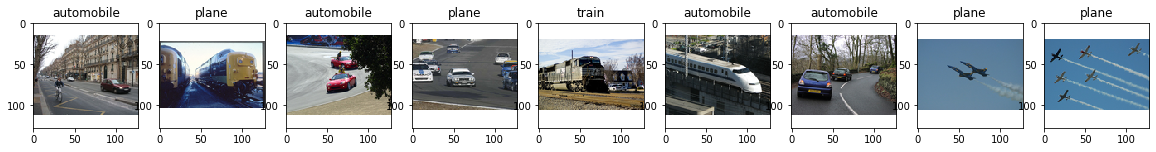

In [31]:
# Load the model
print("Importing the model")
file_stream = open('best_classifier.pkl', 'rb')
clf = pickle.load(file_stream)
file_stream.close()

#get the list of test image files
test_folder = '../data/other/'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color = "white"

fig = plt.figure(figsize=(20, 20))

    
# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
    
    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY) # I first transform the images to gray
                
                # Here is the HOG function
    hog = skimage.feature.hog(gray, block_norm='L2-Hys', pixels_per_cell=(8, 8),
                              cells_per_block=(3, 3), orientations=7,  transform_sqrt=True)
                
    #features.append(hog.ravel())
    
    img_shape = np.array(hog).shape
                      
    # Add the image to the array of images
    image_arrays.append(hog.ravel())

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(rf_classifier, np.array(image_arrays))

image_arrays = []

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
    
    img_shape = np.array(resized_img).shape
                      
    # Add the image to the array of images
    image_arrays.append(resized_img.ravel())

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    img = image_arrays[idx].reshape(img_shape)
    imgplot = plt.imshow(img)
    a.set_title(predictions[idx])

# 7. Conclusion an Suggestions

As can be seen from the predictions, the model seeemed to have overfit a little bit but nonetheless performs way better than the initial baseline, which did geet only 1 out of 9 right in predictions.

Going forward and to combat this overfitting, I would maybe train my model on more images, to make sure it is able to generalize better. Indeed, with the small number of training sample, I believe that its performance is pretty good for a classical approach.

I also believe that more feeaturres could be extracted and coupled with the HOG descriptors.

This pipeline of preprocessing highlighted that with some image transformations, a model can go from bad to great.

Finally, I would like to comment on the transformation that played the biggest role for my model: the histogram of oriented gradients. These descriptors extracted from the training images made the difference for my models, where their performances were the highest.

# 8. References
I have tried referencing all the ressources I have used throuhout my notebook. However, I would like to highlight the following sources without which I would not have been able to complete this notebook without:

- [Tutorial: image classification with scikit-learn](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/)
- [udacity-vehicle-detection-project](https://github.com/hortovanyi/udacity-vehicle-detection-project/blob/master/Vehicle%20Detection%20Project.ipynb)
- [Scikit image: Histogram of Oriented Gradients](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html?highlight=sift)
- [Histogram of Oriented Gradients (and car logo recognition)](https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/#)